# Traffic GAN

## import libraries

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os

from keras import backend as K

from keras.datasets import mnist
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Dropout, Flatten, Input, Lambda, Reshape)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical

In [2]:
# input traffic dimensions
traf_rows =100#100
traf_cols = 2
channels = 1
traf_shape = (traf_rows, traf_cols,channels)

mid_layer = 32

# Size of the noise vector, used as input to the Generator
z_dim = 2

In [3]:
class Dataset:
    def __init__(self, num_labeled):

        # Number labeled examples to use for training
        self.num_labeled = num_labeled

        # Load dataset
        os.chdir('/Users/a-sawabe/Project/1.Programming/gan/traffic-gan/dataset_vsize')

        self.x_train = pd.DataFrame(columns = [])
        self.y_train = pd.DataFrame(columns = [])
        self.x_test = pd.DataFrame(columns = [])
        self.y_test = pd.DataFrame(columns = [])
        _c = 0
        for i in glob.glob("*.csv*"):#("*.csv"):
            tmp = pd.read_csv(i, header=None)
            _tmp = tmp.loc[0:traf_rows-1,:]
            self.x_train = pd.concat([self.x_train, _tmp])
            if 'sensor_b' in i:
                tmp = pd.DataFrame([0])
            elif 'video' in i:
                tmp = pd.DataFrame([1])
            else:
                tmp = pd.DataFrame([2])

            self.y_train = pd.concat([self.y_train, tmp])
            self.x_test = self.x_train
            self.y_test = self.y_train
            
        #print(self.x_train.shape)
        
        #
        def preprocess_trafs(x):
            x = x.values.reshape(-1, traf_rows, traf_cols, 1)
            x[:,0,0] = x[:,0,0]/1500*2-1
            x[:,1,0] = x[:,1,0]/105*2-1
            return x

        def preprocess_labels(y):
            return y.values.reshape(-1, 1)

        # Training data
        self.x_train = preprocess_trafs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)

        # Testing data
        self.x_test = preprocess_trafs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)
        
        print(self.x_train.shape)
        print(self.y_train.shape)
        print(self.x_test.shape)
        print(self.y_test.shape)

    def batch_labeled(self, batch_size):
        # Get a random batch of labeled images and their labels
        idx = np.random.randint(0, self.num_labeled, batch_size)
        trafs = self.x_train[idx]
        labels = self.y_train[idx]
        return trafs, labels

    def batch_unlabeled(self, batch_size):
        # Get a random batch of unlabeled images
        idx = np.random.randint(0, self.x_train.shape[0],
                                batch_size)
        trafs = self.x_train[idx]
        return trafs

    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train

    def test_set(self):
        return self.x_test, self.y_test

In [4]:
# Number of labeled examples to use (rest will be used as unlabeled)
num_labeled = 20

dataset = Dataset(num_labeled)

(30, 100, 2, 1)
(30, 1)
(30, 100, 2, 1)
(30, 1)


# Semi-Supervied GAN

In [5]:
#traf_rows = 2#100
#traf_cols = 2
#channels = 1
#traf_shape = (traf_rows, traf_cols, channels)

# Size of the noise vector, used as input to the Generator
#z_dim = 100

# Number of classes in the dataset
num_classes = 3

## Generator

In [6]:
def build_generator(traf_shape, z_dim):

    model = Sequential()

    # Fully connected layer
    model.add(Dense(mid_layer, input_dim=z_dim))
    
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with tanh activation
    model.add(Dense(traf_rows*traf_cols*channels, activation='tanh'))

    # Reshape the Generator output to image dimensions
    model.add(Reshape(traf_shape))

    return model

## Discriminator

In [7]:
def build_discriminator_net(traf_shape):

    model = Sequential()

    # Flatten the input image
    model.add(Flatten(input_shape=traf_shape))

    # Fully connected layer
    model.add(Dense(mid_layer))
    
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Dense(num_classes))
    #model.add(Dense(num_classes, activation='sigmoid'))

    return model

In [8]:
def build_discriminator_supervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    # Softmax activation, giving predicted probability distribution over the real classes
    model.add(Activation('softmax'))

    return model

In [9]:
def build_discriminator_unsupervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    def predict(x):
        # Transform distribution over real classes into a binary real-vs-fake probability
        prediction = 1.0 - (1.0 /
                            (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction

    # 'Real-vs-fake' output neuron defined above
    model.add(Lambda(predict))

    return model

## Build the Model

In [10]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [11]:
# Core Discriminator network:
# These layers are shared during supervised and unsupervised training
discriminator_net = build_discriminator_net(traf_shape)

# Build & compile the Discriminator for supervised training
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss='categorical_crossentropy',
                                 metrics=['accuracy'],
                                 optimizer=Adam())

# Build & compile the Discriminator for unsupervised training
discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss='binary_crossentropy',
                                   optimizer=Adam())

# Build the Generator
generator = build_generator(traf_shape, z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator_unsupervised.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
# Note that we are using the Discriminator version with unsupervised output
gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss='binary_crossentropy', optimizer=Adam())


## Training

In [12]:
supervised_losses = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        trafs, labels = dataset.batch_labeled(batch_size)
        labels = to_categorical(labels, num_classes=num_classes)
        trafs_unlabeled = dataset.batch_unlabeled(batch_size)
        
        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_trafs = generator.predict(z)

        # Train Discriminator
        d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(trafs, labels)
        d_loss_real = discriminator_unsupervised.train_on_batch(trafs_unlabeled, real)
        d_loss_fake = discriminator_unsupervised.train_on_batch(gen_trafs, fake)
        d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_trafs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, np.ones((batch_size, 1)))

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            supervised_losses.append(d_loss_supervised)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print(
                "%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]"
                % (iteration + 1, d_loss_supervised, 100 * accuracy,
                   d_loss_unsupervised, g_loss))
            
            # Output a sample of generated image
            #sample_images(generator_traf)
            _a = gen_trafs[0]
            _a[:,0,0] = (_a[:,0,0] + 1) * 1500 / 2
            _a[:,1,0] = (_a[:,1,0] + 1) * 105 / 2
            save_file = '../logs/' + str(iteration) + '.csv'
            np.savetxt(save_file,_a[:, :, 0],delimiter=',')


## Train the GAN and Inspect Output

In [13]:
# Set hyperparameters
iterations = 1000
batch_size = 128
sample_interval = 100

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

100 [D loss supervised: 0.0107, acc.: 100.00%] [D loss unsupervised: 0.2261] [G loss: 0.232771]
200 [D loss supervised: 0.0021, acc.: 100.00%] [D loss unsupervised: 0.0878] [G loss: 0.243164]
300 [D loss supervised: 0.0004, acc.: 100.00%] [D loss unsupervised: 0.0449] [G loss: 0.199997]
400 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.0245] [G loss: 0.135122]
500 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0145] [G loss: 0.072931]
600 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0100] [G loss: 0.074978]
700 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0077] [G loss: 0.068162]
800 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0063] [G loss: 0.051162]
900 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0039] [G loss: 0.044895]
1000 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0037] [G loss: 0.044757]


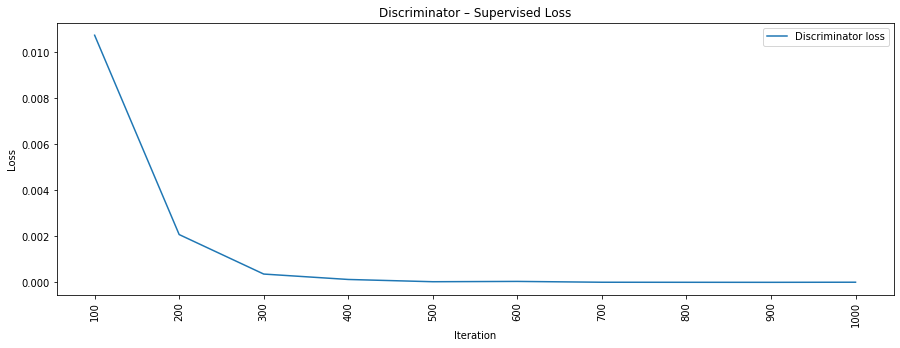

In [14]:
losses = np.array(supervised_losses)

# Plot Discriminator supervised loss
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses, label="Discriminator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Discriminator – Supervised Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()